<a href="https://colab.research.google.com/github/boemer00/stock/blob/main/lstm_model_sp500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas_datareader as web

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM

In [5]:
df = web.DataReader('^GSPC',
                    data_source='yahoo',
                    start='2013-01-01',
                    end='2022-12-12')

df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2013-01-02,1462.430054,1426.189941,1426.189941,1462.420044,4202600000,1462.420044
2013-01-03,1465.469971,1455.530029,1462.420044,1459.369995,3829730000,1459.369995
2013-01-04,1467.939941,1458.989990,1459.369995,1466.469971,3424290000,1466.469971
2013-01-07,1466.469971,1456.619995,1466.469971,1461.890015,3304970000,1461.890015
2013-01-08,1461.890015,1451.640015,1461.890015,1457.150024,3601600000,1457.150024


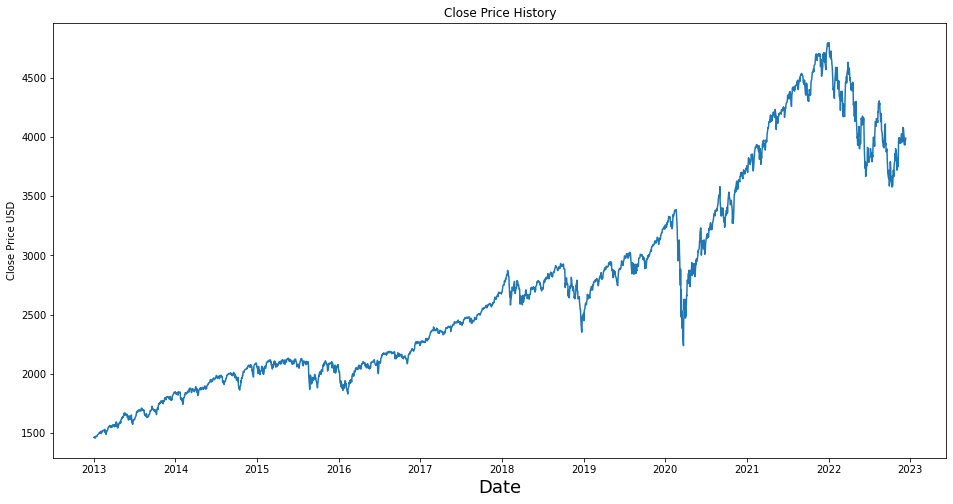

In [6]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD')
plt.show();

In [7]:
# create a new df with only close column
data = df[['Close']]

In [8]:
# convert df to np.array
dataset = data.values

In [9]:
# get number of rows to the train model
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len

2004

In [10]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [11]:
# create training dataset
train_data = scaled_data[:training_data_len, :]

# split data
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

    if i <= 60:
      print(x_train)
      print(y_train)
      print()

[array([0.00157813, 0.00066478, 0.0027909 , 0.00141941, 0.        ,
       0.00115889, 0.00448282, 0.00446187, 0.00405162, 0.00454869,
       0.00463554, 0.00712399, 0.00863325, 0.01060368, 0.01127745,
       0.01128041, 0.01371797, 0.01288552, 0.01517931, 0.01341852,
       0.01226563, 0.01677542, 0.01154693, 0.01621245, 0.01646098,
       0.01564348, 0.01820083, 0.01792532, 0.01865001, 0.01891949,
       0.01923393, 0.01875781, 0.02209669, 0.01641006, 0.01355629,
       0.01750308, 0.00919323, 0.01191525, 0.01761987, 0.0172276 ,
       0.01828165, 0.02037783, 0.02474689, 0.02524696, 0.02608544,
       0.02815768, 0.0296669 , 0.02854695, 0.02915784, 0.03176608,
       0.03100845, 0.02843315, 0.0273072 , 0.03041254, 0.02654661,
       0.02986755, 0.02831037, 0.03192779, 0.03165228, 0.03355081])]
[0.0314486746031018]



In [12]:
# convert to np.arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# reshape data expects 3D
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1944, 60, 1)

In [13]:
# build model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# compile
model.compile(optimizer='adam', loss='mean_squared_error')

# train
model.fit(x_train, y_train, batch_size=1, epochs=1)

1944/1944 [==============================] - 87s 42ms/step - loss: 0.0010


In [14]:
# create testing dataset
# create a new array containing values from index A to B 
test_data = scaled_data[training_data_len-60:,:]

# create the datasets x_test and y_test
# split data
x_test = []
y_test = dataset[training_data_len:,:]

In [15]:
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])

# convert data to np.array (to use it in lstm model)
x_test = np.array(x_test)

# reshape data
# number of rows/samples, time steps (cols), number of features = close price
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [16]:
# predict values
# predictions to contain the same values as our y_test
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# evaluate model (rmse - std of the residuals)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

16/16 [==============================] - 3s 24ms/step


17.000496565462825

<ipython-input-17-a16c015bc36b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


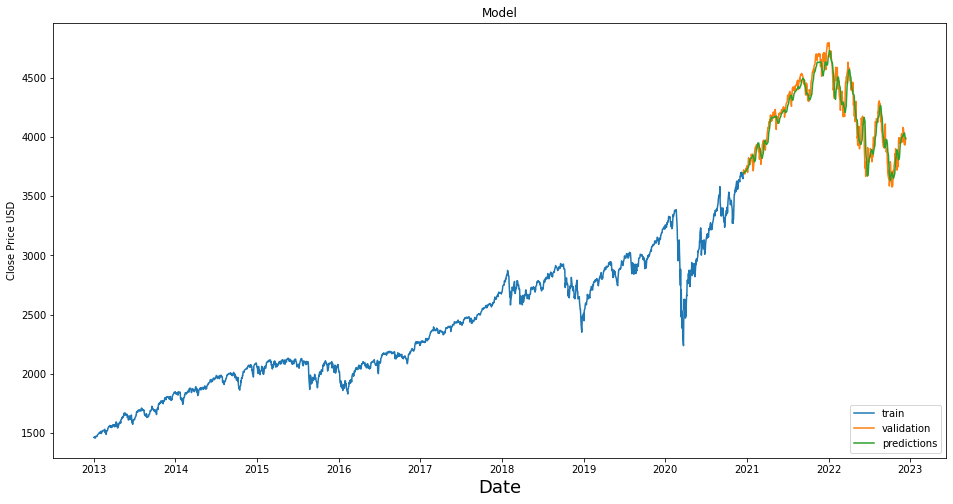

In [17]:
# plot data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']], )
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD')
plt.legend(['train', 'validation', 'predictions'], loc='lower right')
plt.show();

In [19]:
def split_sequences(seq, n_steps_in, n_steps_out):
    X = []
    y = []

    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out

        if out_end > len(seq):
            break
      
        seq_x, seq_y = seq[i:end], seq[end:out_end]

        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
def visualise_results